## 0. Libraries and Personal Tools

In [1]:
import sys


from gc import collect
from os.path import abspath

from re import findall

from numpy import asarray
from pandas import DataFrame
from pandas import cut as pd_cut
from pandas import read_feather, read_csv
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the default figure size and theme to display good looking matplotlib plots.
rcParams["figure.figsize"] = (10, 6)
plt.style.use("fivethirtyeight")

In [3]:
# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

## 1. Get Train Data

In [4]:
df = read_feather(f"../data/interim/small_train_compressed.ftr")
df.set_index(["game_num", "event_id", "event_time"], inplace=True)

In [5]:
# Free some memory after loading the data
collect()

0

## 2. Get Features and Targets

In [6]:
model_features = read_csv("../data/raw/test_dtypes.csv")
FEATURES = [feature for feature in model_features.column.tolist() if feature != "id"]

In [7]:
len(FEATURES)

54

In [8]:
TEAM = "A"
TARGET = f"team_{TEAM}_scoring_within_10sec"
df[TARGET].value_counts(normalize=True, dropna=False)

0    0.941689
1    0.058311
Name: team_A_scoring_within_10sec, dtype: float64

## 3. Train and Test Split

In [9]:
from sklearn.model_selection import GroupShuffleSplit

In [10]:
gsp = GroupShuffleSplit(n_splits=2, test_size=0.3, random_state=777)
train_index, test_index = next(gsp.split(df, groups=df.index.get_level_values("game_num")))

X_train = df[FEATURES].iloc[train_index]
y_train = df[TARGET].iloc[train_index]

X_test = df[FEATURES].iloc[test_index]
y_test = df[TARGET].iloc[test_index]

In [11]:
del df

In [12]:
collect()

0

## 4. Feature Engineering

1. ✅ Impute missing values for player data (position, velocity, and boost)
1. Join distance from two team members to the ball
1. ✅ Distance from the ball to the goal post
1. ✅ Speed of the ball calculated from velocity vector
1. ✅ Speed for each team member calculated from velocity vector
1. Distance from team members to orbs positions
1. Angles between team members and the ball

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

### 4.1 Missing Values (Player Features)

In [14]:
# https://github.com/ResidentMario/missingno
# Messy datasets? Missing values? missingno provides a small toolset of flexible 
# and easy-to-use missing data visualizations and utilities that allows you to 
# get a quick visual summary of the completeness (or lack thereof) of your dataset.
import missingno as msno

In [15]:
player_features = X_train.columns[X_train.columns.str.startswith("p")]

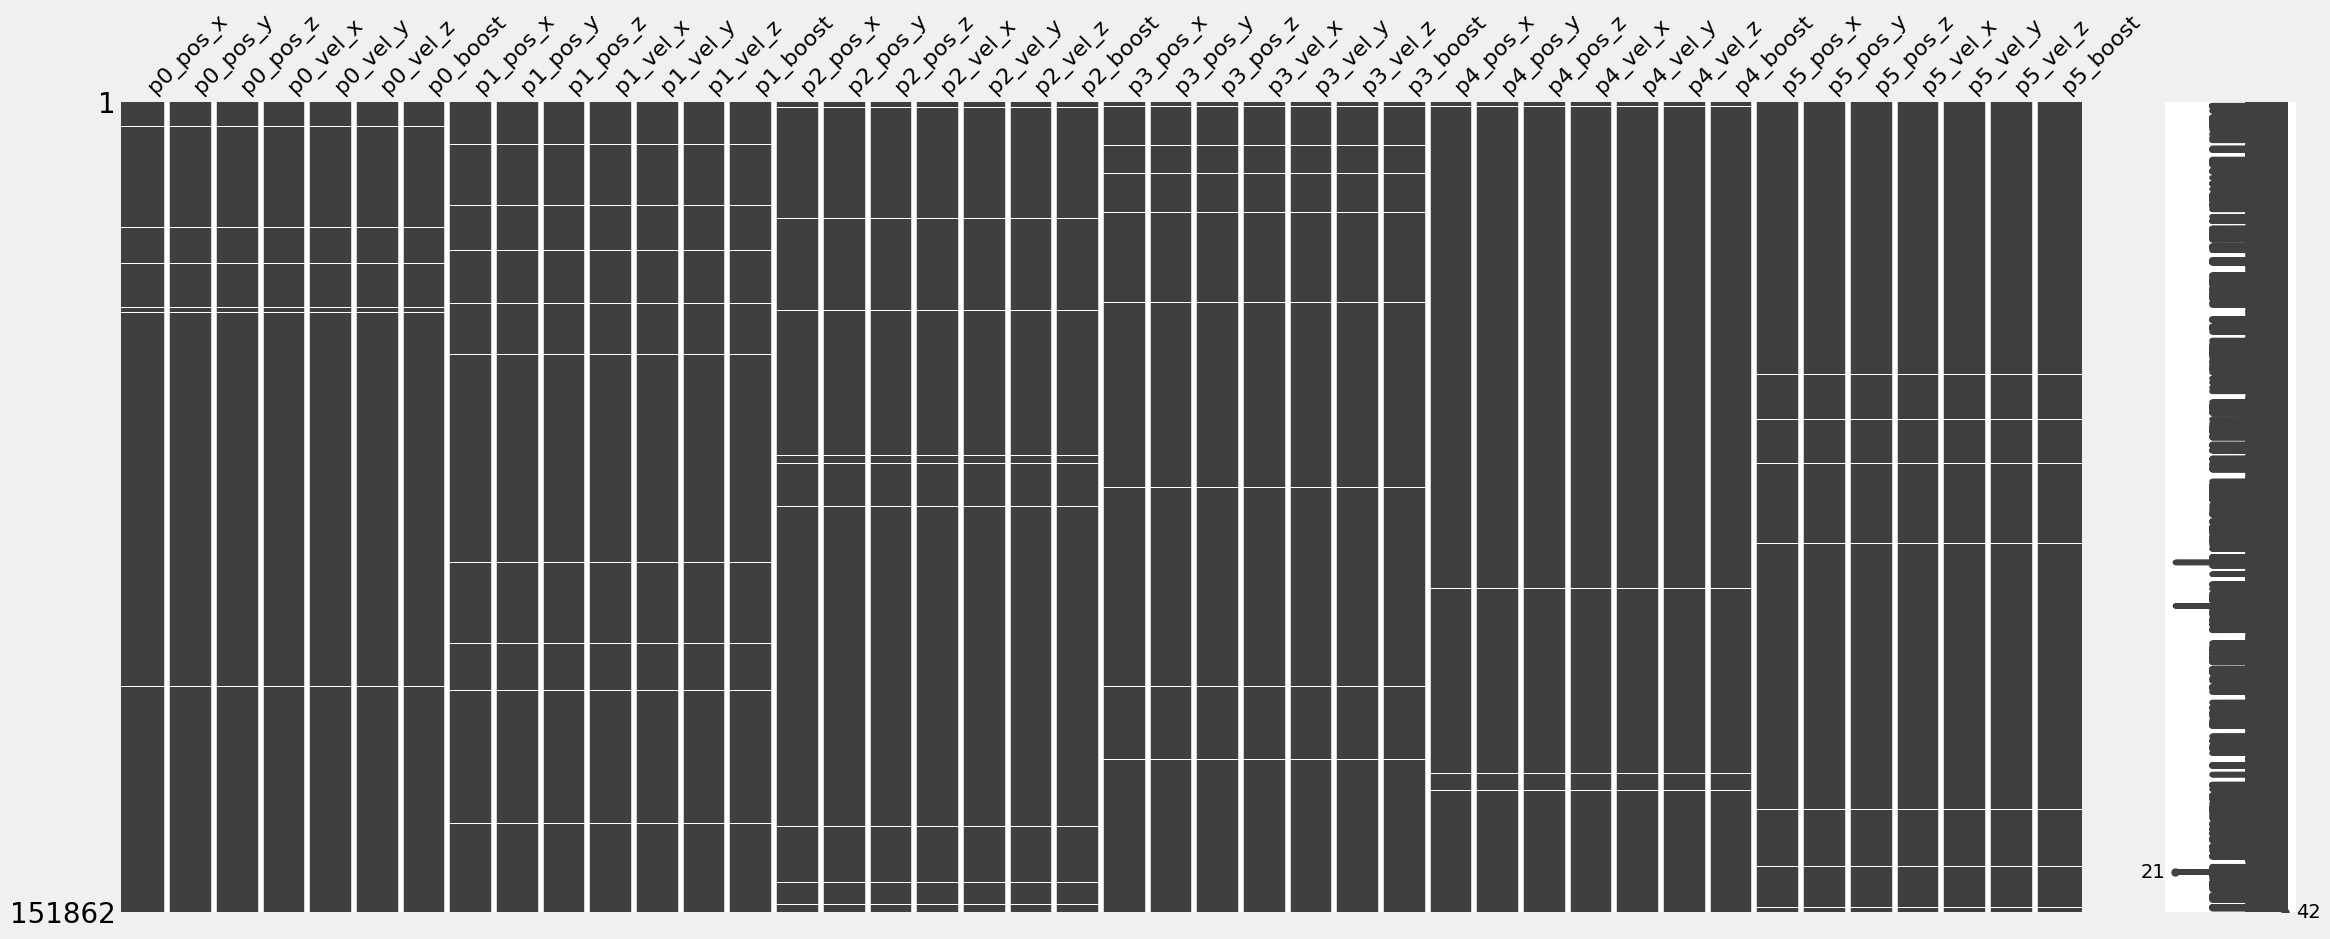

In [16]:
msno.matrix(X_train[player_features].sample(frac=0.1, random_state=777));

#### 4.1.1 Player Demolished

In [17]:
class PlayerDemolished(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        self.feature_names_out = [f"p{i}_demolished" for i in range(6)]
        return self
    
    def transform(self, X):
        X_trans = X.copy()
        for i in range(6):
            player_features = X_trans.columns[X_trans.columns.str.startswith(f"p{i}_")]
            X_trans[self.feature_names_out[i]] = X_trans[player_features].isna().all(axis=1).astype(int)
        return X_trans[self.feature_names_out]

    # TODO: Improve this method
    def get_feature_names_out(self, input_features=None):
        # input_features = _check_feature_names_in(self, input_features)
        return asarray(self.feature_names_out, dtype=object)

### 4.3 Distance from the ball to the goal post

In [18]:
# Check Mahdee's discussion for more details about the goal post
# Source: https://www.kaggle.com/competitions/tabular-playground-series-oct-2022/discussion/357633
GOAL_POST1 = (0.0, -100.0, 6.8)
GOAL_POST2 = (0.0, 100.0, 6.8)

In [19]:
# TODO: Another implementation (using FunctionTransformer) can be found here:
# https://github.com/scikit-learn/scikit-learn/discussions/23992

class DistanceBallGoalPosts(BaseEstimator, TransformerMixin):

    def __init__(self, posts):
        self.posts = posts
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        self.feature_names_out = [f"ball_distance_to_post{i}" for i in range(1, len(self.posts) + 1)]
        return self
    
    def transform(self, X):
        X_trans = X.copy()        
        for i, post in enumerate(self.posts):
            ball_position = ["ball_pos_x", "ball_pos_y", "ball_pos_z"]
            X_trans[self.feature_names_out[i]] = X_trans[ball_position].sub(post).pow(2).sum(axis=1).pow(0.5)
        return X_trans[self.feature_names_out]

    # TODO: Improve this method for all custom transformers
    def get_feature_names_out(self, input_features=None):
        return asarray(self.feature_names_out, dtype=object)

### 4.4 Ball speed from velocity vector

In [20]:
class BallSpeed(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        self.feature_names_out = ["ball_speed"]
        return self
    
    def transform(self, X):
        X_trans = X.copy()     
        ball_velocity = ["ball_vel_x", "ball_vel_y", "ball_vel_z"]   
        X_trans[self.feature_names_out[0]] = X_trans[ball_velocity].pow(2).sum(axis=1).pow(0.5)
        return X_trans[self.feature_names_out]

    def get_feature_names_out(self, input_features=None):
        return asarray(self.feature_names_out, dtype=object)

### 4.5 Player speed from velocity vector

In [21]:
class PlayerSpeed(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        self.feature_names_out = [f"p{i}_speed" for i in range(6)]
        return self
    
    def transform(self, X):
        X_trans = X.copy()
        for i in range(6):
            velocity_vector = [v for v in X_trans.columns if v.startswith(f"p{i}")]
            X_trans[self.feature_names_out[i]] = X_trans[velocity_vector].pow(2).sum(axis=1).pow(0.5)

        return X_trans[self.feature_names_out]

    def get_feature_names_out(self, input_features=None):
        return asarray(self.feature_names_out, dtype=object)

### 4.6 Timer for until big boost is available

In [22]:
class PositiveBoostTimer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.feature_names_out = []
    
    def fit(self, X, y=None):
        self.feature_names_out = [f"p{i}_positive_timer" for i in range(6)]
        return self
    
    def transform(self, X):
        X_trans = X.copy()
        timer_features = X_trans.columns[X_trans.columns.str.endswith("_timer")]
        X_trans[self.feature_names_out] = X_trans[timer_features].abs()
        return X_trans[self.feature_names_out]

    # TODO: Improve this method
    def get_feature_names_out(self, input_features=None):
        # input_features = _check_feature_names_in(self, input_features)
        return asarray(self.feature_names_out, dtype=object)

## 5. Pipeline Building

In [23]:
# Kudos to: https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f
# Kudos to: https://towardsdatascience.com/4-scikit-learn-tools-every-data-scientist-should-use-4ee942958d9e

# from numpy import logical_not, concatenate, asarray
# from numpy import nan as np_nan

# from scipy.spatial.distance import euclidean

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.utils.validation import _get_feature_names, _check_feature_names_in

### 5.1. Player Pipelines

In [24]:
player_position_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MinMaxScaler()),
        ]
)

player_velocity_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MaxAbsScaler()),
        ]
)

player_speed_pipe = Pipeline(
    steps=[
        ("speed", PlayerSpeed()),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ]
)

xaxis_discretizer = FunctionTransformer(pd_cut, kw_args={"bins": range(-85, 86, 10), "labels": False, "retbins": False})
yaxis_discretizer = FunctionTransformer(pd_cut, kw_args={"bins": list(range(-120, 121, 10)), "labels": False, "retbins": False})
zaxis_discretizer = FunctionTransformer(pd_cut, kw_args={"bins": list(range(0, 41, 10)), "labels": False, "retbins": False})

player_position_discretizer_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("xaxis_discretizer", xaxis_discretizer),
        ("yaxis_discretizer", yaxis_discretizer),
        ("zaxis_discretizer", zaxis_discretizer),
        
        ]
)

In [25]:
player_transformations = ColumnTransformer(
    transformers=[
        ("player_demolished", PlayerDemolished(), selector("p[0-5]")),
        ("player_velocity_pipe",  player_velocity_pipe, selector("p[0-5]_vel_")),
        ("player_speed", player_speed_pipe, selector(pattern="p[0-5]_vel_")),
        ("player_position", player_position_pipe, selector("p[0-5]_pos_")),
        ],
    )


### 5.2. Ball Pipelines

In [26]:
ball_velocity_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MaxAbsScaler()),
        ]
)

ball_speed_pipe = Pipeline(
    steps=[
        ("speed", BallSpeed()),
        ("scaler", StandardScaler()),
        ]
)

ball_position_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MinMaxScaler()),
        ]
)

distance_ball_goal_posts_pipe = Pipeline(
    steps=[
        ("distance", DistanceBallGoalPosts(posts=[GOAL_POST1, GOAL_POST2])),
        ("scaler", MinMaxScaler()),
        ]
)

In [27]:
ball_transformations = ColumnTransformer(
    transformers=[
        ("ball_velocity", ball_velocity_pipe, selector("ball_vel_")),
        ("ball_speed", ball_speed_pipe, selector("ball_vel_")),
        ("ball_position", ball_position_pipe, selector("ball_pos_")),
        ("distance_ball_goal_posts", distance_ball_goal_posts_pipe, selector("ball_pos_")),
        ],
    )


### 5.3. Booster Pipelines

In [28]:
booster_timer_pipe = Pipeline(
    steps=[
        ("timer", PositiveBoostTimer()),
        ("scaler", MaxAbsScaler()),
        ]
)

player_boosters_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MaxAbsScaler()),
        ]
)
        

In [29]:
booster_transformations = ColumnTransformer(
    transformers=[
        ("booster_timer", booster_timer_pipe, selector(pattern="boost[0-5]_timer")),
        ("player_boosters", player_boosters_pipe, selector(pattern="p[0-5]_boost")),
        ],
    )

### 5.N. Main Feature Engineering Pipeline

In [30]:
preprocessor = FeatureUnion(
    transformer_list=[
        ("player_transformations", player_transformations),
        ("ball_transformations", ball_transformations),
        ("booster_transformations", booster_transformations),
        ],
    )

In [39]:
from sklearn.feature_selection import VarianceThreshold

In [49]:
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ("variance_threshold", VarianceThreshold(threshold=0.1)),
        ]
    )

In [50]:
X_train.shape

(1518623, 54)

In [51]:
pipe.fit(X = X_train, y = y_train)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player_transformations',
                                                 ColumnTransformer(transformers=[('player_demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f94d0022190>),
                                                                                 ('player_velocity_pipe',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('sca...
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f94fc1b3190>),
                                                                                 ('player_boosters',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MaxAbsScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f94fc1b3a30>)]))])),
                ('variance_threshold', VarianceThreshold(threshold=0.1))])

In [52]:
pipe.n_features_in_

54

In [53]:
len(pipe.get_feature_names_out())
# pipe.get_feature_names_out()

24

## 6. Model Train

In [54]:
pipe.transform(X_test).shape

(630758, 24)